# Active Session 6: State Space Models - I

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cihan-ates/data-driven-engineering/blob/master/DDE_II_Advanced_Topics/Lecture%208/Lecture_8.ipynb)


# Important Note

Lecture notes and notebooks must not be copied and/or distributed without the express permission of ITS.

The notebook is prepared by using the Chapters 1-6 of the Book "[Kalman and Bayesian Filters in Python](https://nbviewer.jupyter.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)".





In [1]:
%pip install filterpy

In [2]:
#Fundamentals
import statistics
import numpy as np
from collections import namedtuple
import filterpy.stats as stats
from numpy.random import randn
from filterpy.stats import plot_gaussian_pdf, gaussian
import random

#filtering

#https://filterpy.readthedocs.io/en/latest/#filterpy-gh
from filterpy.gh import GHFilter
#https://filterpy.readthedocs.io/en/latest/discrete_bayes/discrete_bayes.html
from filterpy.discrete_bayes import predict, normalize
from filterpy.discrete_bayes import update
#https://filterpy.readthedocs.io/en/latest/#filterpy-kalman
import filterpy.kalman as kf
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

#Data generation for Kalman filter:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import copy
import math
#Plotting
import matplotlib as mpl
import plotly.graph_objects as go
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt

In [3]:
import plotting as self_plots

# Alpha beta filter

You may have access the state of a given system via alternative sources: these could be different sensors attached on the system, a predictive model or simply your intuition (lets accept this a black box model) or you can measure the state of the system (lets say temperature) may times with one sensor (thermocouple). In a real world scenerio, non of these sources/measurements will be perfectly accurate, hence we need some sort of transformation fucntion correcting the our understanding of the system via available information.

Here our motiation is to use the available information fully, so we do not want to pick and rely on a relatively more accurate source, but try to use all our sources so as not to eliminate any insights about the state of the system we are interseted in. 

Lets try to build our perspective starting with a simple exercise; temperature measurement. 

Imagine that you are taking repeated measurement within a high pressure, high temperature chamber:

In [4]:
# Creating noisy measurement data:
measurements = np.random.uniform(380, 400, size=10000)
mean = measurements.mean()
print(f'Average of measurements is {mean:.3f}')

Average of measurements is 389.943


The result seems reasonable at first glance; the expected value falls in the middle of our observations. Yet there is a critical assumption here:

Our sensor is assumed to measure the same true temperature (say 390 C) as 380 and 400 with the same likelihood. Well, that is not usually the case, as we expect the sensor to read values closer to the true value most of the time and it should be less likely to print out a value as we get urther away from the true value.  

In [5]:
# Lets implement a likelihood:
mean_val = np.random.normal(390, 5, size=10000).mean()
print(f'Average of measurements is {mean_val:.3f}')

Average of measurements is 390.055


In [6]:
#Lets see the measurements:
mean_val = np.random.normal(390, 5, size=10)
print(mean_val)

[393.76071419 389.74490525 386.29880507 395.50574243 391.24268202
 386.38717826 382.76199889 387.44442706 384.85680646 391.95997472]


Is the temperature increasing, decreasing or are we just seeing a noise? How many times I should measure before deciding a temperature value? It is definitely not practical to make 10k measurements to decide the state of the system! Can we use the trend in the data? Lets continue with temperature example:

In [7]:
temperature = [358.1, 364.7, 360.9, 359.9, 362.8, 364.8, 369.5, 367.9, 366.2, 371.3]
error_1 = np.random.uniform(0, 5, size=len(temperature))
error_2 = np.random.uniform(0, 5, len(temperature))

In [8]:
hypothesis_y = []
[hypothesis_y.append(statistics.mean(temperature)) for i in range(len(temperature))];

In [9]:
self_plots.plotter(temperature,hypothesis_y,error_1,error_2)

It is clearly seen that mean approximation fails to capture the trend in the data, indicating a dynamical change in the state of the system. Maybe a better option could be some sort of trend fitting? 

In [10]:
poly = np.polyfit(list(range(len(temperature))), temperature, 1)

In [11]:
new_hypothesis = []
[new_hypothesis.append(poly[0]*i + poly[1]) for i in range(len(temperature))];

In [12]:
self_plots.plotter(temperature,new_hypothesis,error_1,error_2)

Here we have reached a bifurcation point: does my hypothesis reflect the true dynamics of the system? In other words, do I need to make additional measurements to further predict the state of the system or I am fine with the model (hypothesis) I have? 

What we are interested here is a complex dynamical system, for which the state may evolve different than my current predictions. What we are after is a dynamical model, that can reflect the changes in the states I measure, different than my prior knowledge on the system. Therefore, we are going to use two sources of information (model and measurements) to update our understanding of the system (can you see the recurrent logic here as well?).

Lets imagine a case where we have start making new measurements and we have the model we have derived above. Our objective is to find a way to update our understanding of the system.

Lets return back to our example. 

In [13]:
# Consider that we have recorded the following degrees with given delta_t:
temp_observations = [358.3, 364.8, 360.6, 359.5, 362.8, 364.2, 369.9, 367.7, 366.2, 371.4, 371.4, 372.7]
delta_t = 1.0  
#
#Prior knowledge: assume that we trust our measurement more than our model:
scaling_factor = 0.618

We will use our model output and the observation to make new predictions:

$\mathtt{estimation_{t}} = \mathtt{prediction_{t}} + 0.618(\mathtt{measurement_{t}} - \mathtt{prediction_{t}})$

Lets write a function accordingly:

In [14]:
def state_predict(estimated_temp, gain_rate, isPrint=False):     
    # storage for the filtered results
    estimations, predictions = [estimated_temp], []

    for z in temp_observations: 
        # predict new position via our model:
        predicted_temp = estimated_temp + gain_rate * delta_t

        # updating the "filter": here we will combine the information
        # coming from the model and the measurement:
        estimated_temp = predicted_temp + scaling_factor * (z - predicted_temp)

        if isPrint:
            print(f'prior estimation: {estimations[-1]:.1f}',
                  f'model prediction: {predicted_temp:.1f}',
                  f'estimation: {estimated_temp:.1f}')
        
        # Saving the loop state:
        estimations.append(estimated_temp)
        predictions.append(predicted_temp)

    return estimations, predictions

In [15]:
#Calling our function:
initial_temp = 360.0
estimations, predictions = state_predict(estimated_temp=initial_temp, gain_rate=poly[0], isPrint=True)  

prior estimation: 360.0 model prediction: 361.2 estimation: 359.4
prior estimation: 359.4 model prediction: 360.6 estimation: 363.2
prior estimation: 363.2 model prediction: 364.4 estimation: 362.0
prior estimation: 362.0 model prediction: 363.2 estimation: 360.9
prior estimation: 360.9 model prediction: 362.1 estimation: 362.5
prior estimation: 362.5 model prediction: 363.7 estimation: 364.0
prior estimation: 364.0 model prediction: 365.2 estimation: 368.1
prior estimation: 368.1 model prediction: 369.3 estimation: 368.3
prior estimation: 368.3 model prediction: 369.5 estimation: 367.5
prior estimation: 367.5 model prediction: 368.6 estimation: 370.3
prior estimation: 370.3 model prediction: 371.5 estimation: 371.4
prior estimation: 371.4 model prediction: 372.6 estimation: 372.7


Lets assume that our model roughly capture the true dynamics of the system (~ over-estimates). Lets see the impact of our filtering on the estimations:

In [16]:
true_data = []
[true_data.append(poly[0]*i*0.85 + 360.0) for i in range(len(temp_observations)+1)];

In [17]:
self_plots.plotter_2(temp_observations, predictions, estimations, true_data)

Our estimations are getting better as we move in time, which lies in between the measurements and the model predictions.

Since the current dynamics of the system is not that different than our model insight (in terms of the trends), we do an acceptable job. Question is, what happens when we enter a different regime, or shifting to a different equilibrium state? 

Lets image that our model states that we are expecting a decrease in the temperature. Can measurements help us to correct this mistake?

In [18]:
#Calling our function:
initial_temp = 360.0
# note that we reverse the slope of the model to reflect the insight on decreasing temperatures:
estimations, predictions = state_predict(estimated_temp=initial_temp, gain_rate=-poly[0], isPrint=True)  

prior estimation: 360.0 model prediction: 358.8 estimation: 358.5
prior estimation: 358.5 model prediction: 357.3 estimation: 361.9
prior estimation: 361.9 model prediction: 360.8 estimation: 360.7
prior estimation: 360.7 model prediction: 359.5 estimation: 359.5
prior estimation: 359.5 model prediction: 358.3 estimation: 361.1
prior estimation: 361.1 model prediction: 359.9 estimation: 362.6
prior estimation: 362.6 model prediction: 361.4 estimation: 366.6
prior estimation: 366.6 model prediction: 365.5 estimation: 366.8
prior estimation: 366.8 model prediction: 365.7 estimation: 366.0
prior estimation: 366.0 model prediction: 364.8 estimation: 368.9
prior estimation: 368.9 model prediction: 367.7 estimation: 370.0
prior estimation: 370.0 model prediction: 368.8 estimation: 371.2


In [19]:
self_plots.plotter_2(temp_observations, predictions, estimations, true_data)

This does not look so good. We can still make estimations that yield an increasing trend but the difference between the truth gets larger. In other words, if we just simple combine our prior understanding on the dynamics of the system with the measurements without updating our "view of the world", the filter will fail when there is change in the system behavior. 

What could be the solution? Remember that we pass our prior knowledge in the form of a "gain", which was fixed based on our previous knowledge. 

Here the trick is convert the gain parameter into a variable that is learning from our measurements and estimations.

In [20]:
# Lets rewrite our function:
#We need to define a learning rate for the gain update:
learning_rate = 1.0-0.618

def state_predict_2(estimated_temp, gain_rate, isPrint=False):     
    # storage for the filtered results
    estimations, predictions = [estimated_temp], []

    for z in temp_observations: 
        # predict new position via our model:
        predicted_temp = estimated_temp + gain_rate * delta_t

        #Updating our understanding of the "world":
        #we will use the difference btw. the prediction and the measurement as a scaling factor
        #we will add temporal information by dividing to delta_t => residual/time
        #this will be multiplied with learning rate to update previous gain.
        residual = z - predicted_temp
        gain_rate = gain_rate + learning_rate * (residual/delta_t)
        
        # updating the "filter": here we will combine the information
        # coming from the model and the measurement:
        estimated_temp = predicted_temp + scaling_factor * (z - predicted_temp)

        if isPrint:
            print(f'prior estimation: {estimations[-1]:.1f}',
                  f'model prediction: {predicted_temp:.1f}',
                  f'estimation: {estimated_temp:.1f}')
        
        # Saving the loop state:
        estimations.append(estimated_temp)
        predictions.append(predicted_temp)

    return estimations, predictions

In [21]:
#Calling our function:
initial_temp = 360.0
# note that we reverse the slope of the model to reflect the insight on decreasing temperatures:
estimations, predictions = state_predict_2(estimated_temp=initial_temp, gain_rate=-poly[0], isPrint=True)  

prior estimation: 360.0 model prediction: 358.8 estimation: 358.5
prior estimation: 358.5 model prediction: 357.1 estimation: 361.9
prior estimation: 361.9 model prediction: 363.4 estimation: 361.7
prior estimation: 361.7 model prediction: 362.2 estimation: 360.5
prior estimation: 360.5 model prediction: 360.0 estimation: 361.7
prior estimation: 361.7 model prediction: 362.3 estimation: 363.5
prior estimation: 363.5 model prediction: 364.7 estimation: 367.9
prior estimation: 367.9 model prediction: 371.2 estimation: 369.0
prior estimation: 369.0 model prediction: 371.0 estimation: 368.0
prior estimation: 368.0 model prediction: 368.1 estimation: 370.1
prior estimation: 370.1 model prediction: 371.5 estimation: 371.4
prior estimation: 371.4 model prediction: 372.8 estimation: 372.7


In [22]:
self_plots.plotter_2(temp_observations, predictions, estimations, true_data)

By comparing the measurements and our model predictions, we created a feedback information, which is then used to update our understanding of the system; that is the gain variable. Here we see that our estimations are much better than pure model predictions and learn the new dynamics in a few steps.

Note that we have some parameters here: learning_rate & scaling factor, which are chosen arbitrarily here. We could also use update the gain; take another model prediction; maybe avarage them and so on. The key idea here is to keep update our understanding of the system as new information becomes available.

##  $\alpha$-$\beta$ filter

Above discussions and the algoithm we worked on id formally called  $\alpha$-$\beta$ filter or g-h filter in the literature. There are many filter applications in the literature and they are, in one way or the other, interpretations of these two hyperparameters:

+ $\alpha$ is the scaling factor between the measurement and the prediction. If $\alpha$ is very small; we ignore the information coming from the measurements. If it is too large; we rely on the measurements too much hence reject very little of the noise (errors) in the measured values.

+ $\beta$ is the scaling factor between the measured residual and the model prediction, hence can be considered as a form of learning rate. A small $\beta$ value means we react to the changes in the landscape rather slowly.


For instance, in Kalman filter, $\alpha$-$\beta$ are varried dynamically at each time step, which we will see later.

### Using filterpy

In [23]:
# Creating a sensor readings for our simple filter:
def new_position(pos, vel, dt=1.):
    return pos + (vel * dt)
def measured_position(pos):
    return pos + randn()*300
def gen_data(pos, vel, count):
    z = []
    for t in range(count):
        pos = new_position(pos, vel)
        vel += 0.2
        z.append(measured_position(pos))
    return np.asarray(z)
  
pos, vel = 30000., 15.
z = gen_data(pos, vel, 100)

In [24]:
z[:10]

array([29839.77543369, 29806.72659737, 30256.68074508, 30261.85269332,
       30396.97753924, 29966.68070575, 29909.48209862, 30334.45624217,
       30195.61219447, 30468.89539274])

In [25]:
x = pos
dx = vel
#Creating filter:
#https://filterpy.readthedocs.io/en/latest/gh/GHFilter.html
f_object = GHFilter(x,dx,dt=1,g=0.01,h=0.01)
print('x:',f_object.x)
print('dx:',f_object.dx)

x: 30000.0
dx: 15.0


In [26]:
#Applying the filter with measurements z:
x_estimates = []
for measurement in z:
  x_estimates.append(f_object.update(z = measurement)[0])
x_estimates = np.array(x_estimates)


In [27]:
#lets see the output of .update on f_object
f_object

GHFilter object
dt = 1
g = 0.01
h = 0.01
x = 32337.904706776262
dx = 26.79157904065614
x_prediction = 32338.54292730415
dx_prediction = 27.429799568544656
y = -63.82205278885158
z = 0.0

In [28]:
self_plots.plotter_2(z/1000,[],x_estimates/1000,[])

### Impact of filter parameters

In [29]:
x = pos
dx = vel
#Creating filter:
#https://filterpy.readthedocs.io/en/latest/gh/GHFilter.html
f_object = GHFilter(x,dx,dt=1,g=0.3,h=0.01)

In [30]:
#Applying the filter with measurements z:
x_estimates = []
for measurement in z:
  x_estimates.append(f_object.update(z = measurement)[0])
x_estimates = np.array(x_estimates)


In [31]:
self_plots.plotter_2(z/1000,[],x_estimates/1000,[])

When we increase $\alpha$ value, our estimates relies more on the measurement. If we look at the data, however, there are lots of noise so we should limit the influence of measurements. 

In [32]:
x = pos
dx = vel
#Creating filter:
#https://filterpy.readthedocs.io/en/latest/gh/GHFilter.html
f_object = GHFilter(x,dx,dt=1,g=0.001,h=0.1)

In [33]:
#Applying the filter with measurements z:
x_estimates = []
for measurement in z:
  x_estimates.append(f_object.update(z = measurement)[0])
x_estimates = np.array(x_estimates)


In [34]:
self_plots.plotter_2(z/1000,[],x_estimates/1000,[])

Here we have increased the $\beta$ value. It means that our filter become more sensitive to changes in dx; it even reacts to the noise in the data. 

In [35]:
x = pos
dx = vel
#Creating filter:
#https://filterpy.readthedocs.io/en/latest/gh/GHFilter.html
f_object = GHFilter(x,dx,dt=1,g=0.0001,h=0.003)

In [36]:
#Applying the filter with measurements z:
x_estimates = []
for measurement in z:
  x_estimates.append(f_object.update(z = measurement)[0])
x_estimates = np.array(x_estimates)


In [37]:
self_plots.plotter_2(z/1000,[],x_estimates/1000,[])

# [Bayesian](https://en.wikipedia.org/wiki/Bayesian_probability) Filtering

We have seen that our understanding of the system and how we update this knowledge has a significant impact on the predictive accuracy of our filtering operation. 

While building our knowledge towards Kalman filters, we will make a quick stop in Bayesian learning (If you would like to revise the concept, you may check Lecture 4 of DDE-I) and how we can use this strategy to update our understanding of the "world".


The beauty of the Bayesian approach is the way it interprets and updates the past knowledge (i.e. prior):

$\mathtt{posterior} = \frac{\mathtt{likelihood}\times \mathtt{prior}}{\mathtt{evidence}}$

which can be translated into the following algorithm for our problem:

1. initialize the prior knowledge,

2. predict the state for the next time step,

3. measure the state, 

4. set a belief about the measurement accuracy,

5. compute how likely the measurement matches the state,

6. update our knowledge with this likelihood (posterior)

We will dicuss the idea behind Bayesian learning over a traditional example.

### Problem definition: A classic case

Imagine that we are trying to predict the position of a robot along a 1D path (along its railway) given an order to move a set position:

+ We may not have infromation about the initial state, that is where the robot is. 

+ We may know how it moves between discrete positions.  

+ We may also know how it moves: it goes through states following one another: 1=>2; 4=>5 etc.

+ We should consider the error in order execution (due to rail slipping, motor errors etc.)

+ We should consider the error from the sensory data (imagine that we have an array of magnets and we can count how many checkpoints we have passed along the movement).

In [38]:
class Sensor_measurements(object):

    def __init__(self, track_len, kernel=[1.], sensor_accuracy=.9):
        self.track_len = track_len
        self.pos = 0
        self.kernel = kernel
        self.sensor_accuracy = sensor_accuracy

    def move(self, distance=1):
        """ moves in the specified direction
        with some small chance of error"""
        self.pos += distance
        # adding randomness
        r = random.random()
        s = 0
        offset = -(len(self.kernel) - 1) / 2
        for k in self.kernel:
            s += k
            if r <= s:
                break
            offset += 1
        self.pos = int((self.pos + offset) % self.track_len)
        return self.pos

    def sense(self):
        pos = self.pos
         # insert random sensor error.
         #Is there an error?
        if random.random() > self.sensor_accuracy:
            #is it positive or negative?
            if random.random() > 0.5:
                pos += 1
            else:
                pos -= 1
        return pos

In [39]:
def f_likelilood(path, z, accuracy_sensor):
    """ Made up function. Computes likelihood that a measurement matches positions."""   
    try:
        scale = accuracy_sensor / (1. - accuracy_sensor)
    except ZeroDivisionError:
        scale = 1e8
    likelihood = np.ones(len(path))
    likelihood[path==z] *= scale
    return likelihood

In [40]:
def bar_plot(pos, x=None, ylim=(0,1), title=None,color='#30a2da'):
    ax = plt.gca()
    if x is None:
        x = np.arange(len(pos))
    ax.bar(x, pos,color=color)
    if ylim:
        plt.ylim(ylim)
    plt.xticks(np.asarray(x), x)
    if title is not None:
        plt.title(title)

In [41]:
#Creating the filter
def DBF(iterations, kernel, sensor_accuracy, 
             move_distance, do_print=True):
    #Positions on the robot's track:
    track = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
    #Our estimate on the location of the robot:
    prior = np.array([.9] + [0.01]*9)
    #initialize:
    posterior = prior[:]
    # create pdf:
    normalize(prior)
    #Calling the sensor object:
    robot = Sensor_measurements(len(track), kernel, sensor_accuracy)
    
    #Simulating...
    for i in range(iterations):

        #moving the robot:
        robot.move(distance=move_distance)

        #peforming prediction step:"predict"
        #Performs the discrete Bayes filter prediction step, generating the prior
        prior = predict(posterior, move_distance, kernel)       

        # updating the filter: 
        # getting the noisy sensor data
        m = robot.sense()
        # calculating likelihood from a made-up function:
        likelihood = f_likelilood(track, m, sensor_accuracy)
        # calcuating the posterior:
        posterior = update(likelihood, prior)
        index = np.argmax(posterior)
        

        if do_print:
            print(f'time {i}: pos {robot.pos}, sensed {m}, at position {track[robot.pos]}')
            conf = posterior[index] * 100
            print(f'        estimated position is {index} with confidence {conf:.4f}%:')            

    if do_print:
        print()
        print('final position is', robot.pos)
        index = np.argmax(posterior)
        print('''Estimated position is {} with '''
              '''confidence {:.4f}%:'''.format(
                index, posterior[index]*100))
    bar_plot(posterior)

time 0: pos 1, sensed 1, at position 1
        estimated position is 1 with confidence 99.9900%:
time 1: pos 2, sensed 2, at position 2
        estimated position is 2 with confidence 100.0000%:
time 2: pos 3, sensed 3, at position 3
        estimated position is 3 with confidence 100.0000%:
time 3: pos 4, sensed 4, at position 4
        estimated position is 4 with confidence 100.0000%:

final position is 4
Estimated position is 4 with confidence 100.0000%:


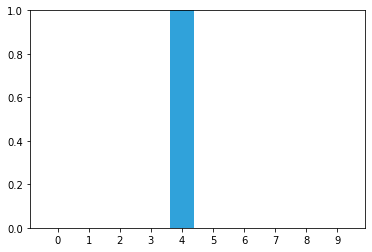

In [42]:
# Using the filter:
#Random number:
random.seed(7)
np.set_printoptions(precision=2, suppress=True, linewidth=80)
DBF(4, kernel=[1.], sensor_accuracy=.999, move_distance=1, do_print=True)



time 0: pos 2, sensed 2, at position 2
        estimated position is 2 with confidence 80.3283%:
time 1: pos 4, sensed 3, at position 4
        estimated position is 3 with confidence 47.2815%:
time 2: pos 6, sensed 6, at position 6
        estimated position is 6 with confidence 62.1856%:
time 3: pos 8, sensed 8, at position 8
        estimated position is 8 with confidence 71.7022%:

final position is 8
Estimated position is 8 with confidence 71.7022%:


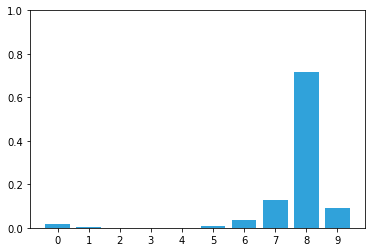

In [43]:
#Now lets introduce some noise:
random.seed(77)
DBF(4, kernel=[.2, .6, .2], sensor_accuracy=.77,move_distance=2, do_print=True)

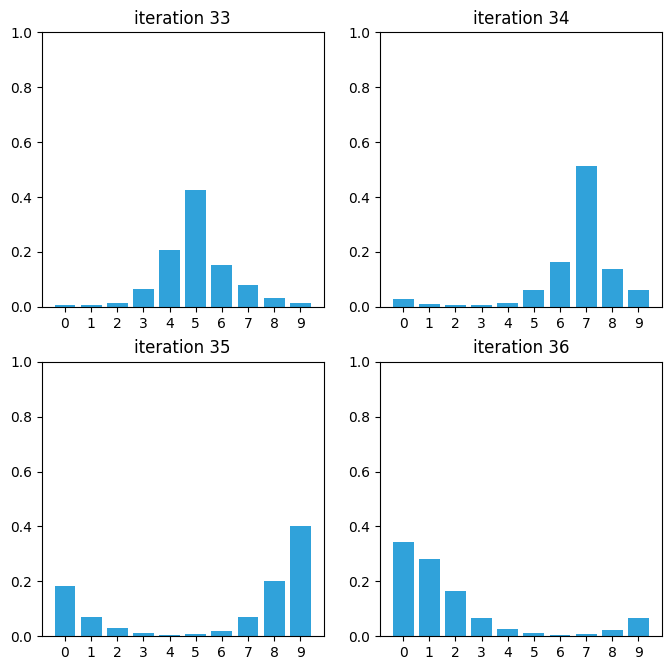

In [44]:
plt.figure(figsize=(8,8), dpi=100)
for i in range (4):
    random.seed(11)
    plt.subplot(221+i)
    DBF(33+i, kernel=[.15, .7, .15], 
                  sensor_accuracy=.66,
                  move_distance=2, do_print=False)
    plt.title (f'iteration {33 + i}')
    



## Shifting from discrete data to continuous data

Although instructive, the previous approach is not very useful in real-life scenerios as we would like to have a continuous view of the world. Therefore, we need a continuous way to represent probabilities and we need to do it in a computationally efficient way. 

## Gaussian distributions

Lets remember how one of the most famous equations in the world looks like when plotted:

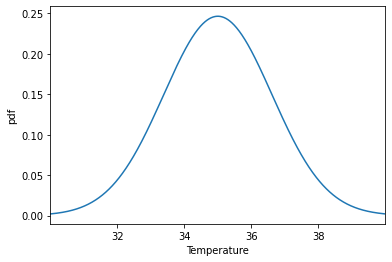

In [45]:
plot_gaussian_pdf(mean=35, variance=1.618**2, xlabel='Temperature', ylabel='pdf');

Assume that we have a thermocouple and are measuring the ambient temperature. At a certain instance, we read it as 34.2. We know that no tool is perfect so it is very unlikely that the exact temperature is 34.2 (it is funny to think that temperature itself is a statistics and telling us how fast molecules move in average). 

Here we assume based on the central limit theorem that we make enough number of measurements, these points will be **normally distributed**. In the plot, we see that 35 is the more likely option. 



In a probability density function, the area under the curve yields "1". 

What happens if we have several cases with the same mean but different variances:

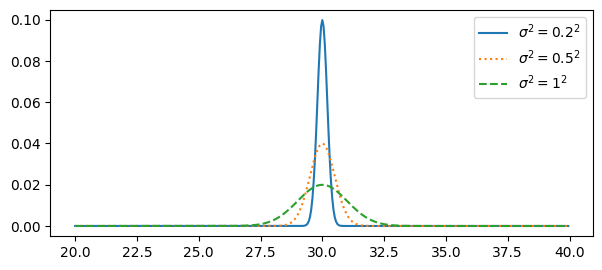

In [46]:
plt.figure(figsize=(7,3), dpi=100)
xs = np.arange(20, 40, 0.05)
plt.plot(xs, gaussian(xs, 30, 0.2**2), label='$\sigma^2=0.2^2$')
plt.plot(xs, gaussian(xs, 30, .5**2), label='$\sigma^2=0.5^2$', ls=':')
plt.plot(xs, gaussian(xs, 30, 1**2), label='$\sigma^2=1^2$', ls='--')
plt.legend();

They all tell us that the expected value is 30, but their confidences in this decision is not the same! This is a very critical interpretation for our objective.

Lets continue to play with Gaussians. 

If we consider the mathematical details of the above calculations, we did add and multiply arbitrary probability distributions. In other words, if we rely on a continuous function, we will need to add and multply them. In the case of Gaussian, we see that the sum of two normal variables is also normally distributed. The multiplication, on the other hand, gives a Gaussian function (output is proportional to Gaussian distribution). 

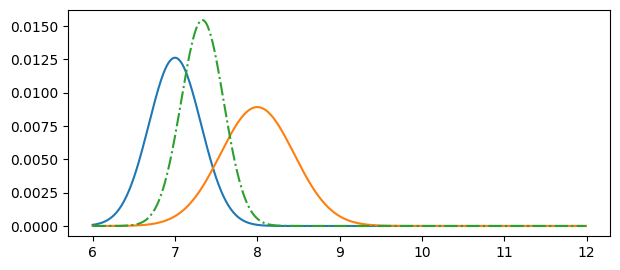

In [47]:
x = np.arange(6, 12, 0.01)
g1 = gaussian(x, mean=7, var=.1)
g2 = gaussian(x, mean=8, var=.2)
plt.figure(figsize=(7,3), dpi=100)
plt.plot(x, g1, x, g2)
# element-wise multiplication:
g = g1 * g2  
# Converting into Gaussian:
g = g / sum(g)  
plt.plot(x, g, ls='-.');
plt.show()

This property is what makes Gaussians a suitable candidate to represent uncertainity in filtering.

# Combining Gaussians with Bayesian Statistics: 1D Kalman Filters

Now we are ready to combine what we have gone over so far: "discrete Bayesian + Gaussian".

In short, Kalman filters are Bayesian filters using Gaussians in the probability representations. Herein, the first step is the representation of our initial belief (previously it was a discrete list). 

You can consider the transformation changing from the discrete list representations (via convolution) to **cont. embedding** with a predefined function: many data points is mapped via two parameters: mean and the variance.

## Finding prior

We will perform our calculations with Gaussians having two elements. Hence it is a good idea to use tuple structure. Below we define a special file format via `namedtuple`:

In [48]:
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])
g1 = gaussian(1.618, 0.314)
g2 = gaussian(mean=0.618, var=0.0271)
print(g1)
print(g2)

𝒩(μ=1.618, 𝜎²=0.314)
𝒩(μ=0.618, 𝜎²=0.027)


Lets return to our basic problem of object tracking and define the prior from the current velocity and the previous position:

\begin{equation}
\begin{split}
\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x
 \end{split}
\end{equation}


In [49]:
#Calculating prior:
pos = gaussian(11., .3**2)
move = gaussian(12., .6**2)

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

predict(pos, move)

𝒩(μ=23.000, 𝜎²=0.450)

## Calculating posterior

Similarly, we will  replace the discrete update function with a Gaussian. 

We previously multiple prior with the likelihood and then returned the normalized value (this actually corresponds to the division by the evidence):
```
def update(likelihood, prior):
    posterior = likelihood * prior
    return normalize(posterior)
```

If we do the same multiplication with Gaussians, we first need to define `likelihood`. As a matter of fact, likelihood is the probability of the measurement given the current state and we can define it as a Gaussian:

\begin{equation}
\mathcal{N}(\mu_z, \sigma_z^2)
\end{equation}

Note that multiplication of two Gaussian distribution is not a distribution but a function, which can be converted to a Gaussian distribution via normalization:



\begin{equation}
\begin{split}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&= \| \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \|\\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{split}
\end{equation}


For the update, we need to code the above equation:

In [50]:
def gaussian_multiply(g1, g2):
    #Note that we are using tuples:
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

In [51]:
# test the update function
predicted_position = gaussian(10., .21**2)
measured_position = gaussian(12., .23**2)
estimated_position = update(predicted_position, measured_position)
estimated_position

𝒩(μ=10.909, 𝜎²=0.024)

### How does it help?

In Bayesian approach, we learn via combining our prior knowledge with our current observation. But how does Gaussian multiplication work in this frame? Lets see over a simple exercise.


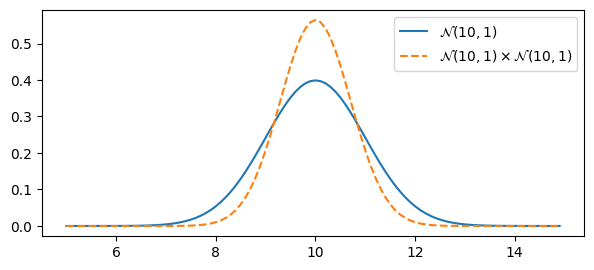

In [52]:
# Imagine that we take two measurements, which are identical.
# Our sensor is not perfect we are expecting a variance:
z = gaussian(10., 1.)  
# Lets multiply the Gaussians as we do in the update:
product = gaussian_multiply(z, z)
# Getting a range for plotting:
xs = np.arange(5, 15, 0.1)
#
# Using filterpy stats to create data points for the Gaussian:
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.figure(figsize=(7,3), dpi=100)
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')
# Using filterpy stats to create data points for the multiplication:
ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--');
plt.legend()
plt.show()

In [53]:
print(product)

𝒩(μ=10.000, 𝜎²=0.500)


This is a very important illustration, as shows us how our confidence in the predictions increase as we make similar measurements.

Now we will look at another example; where we have two different measurements with the same sensitivies: 

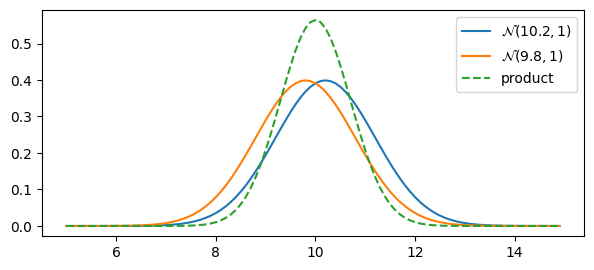

In [54]:
# Note that the variances are the same:
z1 = gaussian(10.2, 1)
z2 = gaussian(9.8, 1)
self_plots.plot_products(z1, z2)

We again see that our confidence increases with increasing number of measurements. Moreover, for the measurements with the same reliability, they meet in the middle. 

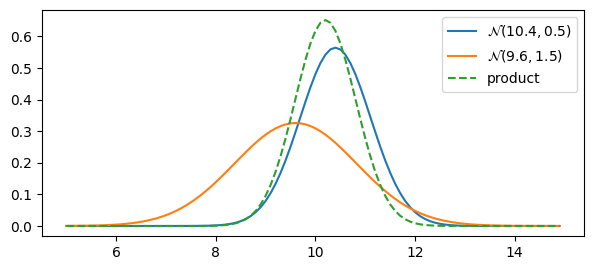

In [55]:
# Note that the variances are the different:
z1 = gaussian(10.4, .5)
z2 = gaussian(9.6, 1.5)
self_plots.plot_products(z1, z2)

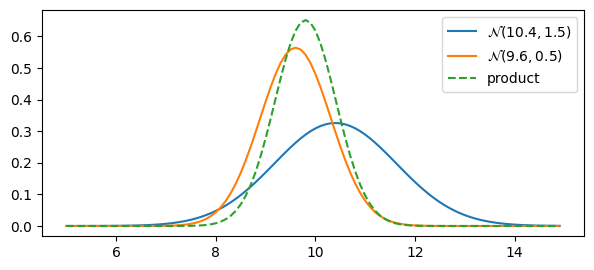

In [56]:
# Note that the variances are the different:
z1 = gaussian(10.4, 1.5)
z2 = gaussian(9.6, 0.5)
self_plots.plot_products(z1, z2)

## Kalman Filtering: putting all together

We are ready to combine all the tools we discussed so for to test the Kalman filter.

We will use artificially generated data for a wandering robot in 1D space. 

In [57]:
# The class RobotSimulator is here to generate data to be used in 
# Kalman filter. It is modified from the textbook "Kalman and Bayesian Filters in Python".

class RobotSimulator(object):

    def __init__(self, x0=0, velocity=1,
                 measurement_var=0.0, process_var=0.0):
        """ x0 - initial position
            velocity - (+=right, -=left)
            measurement_variance - variance in measurement m^2
            process_variance - variance in process (m/s)^2
        """
        self.x = x0
        self.velocity = velocity
        self.measurement_noise = math.sqrt(measurement_var)
        self.process_noise = math.sqrt(process_var)

    def move(self, dt=1.0):
        '''Compute new position of the robot assuming `dt` seconds have
        passed since the last update.'''
        # compute new position based on velocity with some process noise
        velocity = self.velocity + randn() * self.process_noise * dt
        self.x += velocity * dt

    def sense_position(self):
        # measuring the position with noise
        return self.x + randn() * self.measurement_noise

    def move_and_sense(self, dt=1.0):
        self.move(dt)
        x = copy.deepcopy(self.x)
        return x, self.sense_position()

    def run_simulation(self, dt=1, count=1):
        """ simulate the robot moving over a period of time.
        **Returns**
        data : np.array[float, float]
            2D array, first column contains actual position of the robot,
            second column contains the measurement of that position
        """
        return np.array([self.move_and_sense(dt) for i in range(count)])

Lets run the simulation for preset variances in the process (robot moving given an order) and the sensor.

In [58]:
# Random seeding:
np.random.seed(11)

#Setting the variances:
process_variance = 0.0618 # variance for the movement of the robot
sensor_variance = 0.333  # variance in the sensory measurements

# Initial position: imagine that we are not confident in this information.
x = gaussian(0., 23.**2)  
velocity = 1
dt = 1. # time step in seconds

print(x, x.mean, x.var)

𝒩(μ=0.000, 𝜎²=529.000) 0.0 529.0


In [59]:
#Defining our process model: how robot moves. We will ignore accelaration effects.
process_model = gaussian(velocity, process_variance) 
print(process_model)

𝒩(μ=1.000, 𝜎²=0.062)


In [60]:
# We have an initial position and a model telling us how the robot moves.
# Lets use the simulator to generate data:
robo_x = RobotSimulator(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_variance, 
    process_var=process_model.var)

In [61]:
# creating the data...
data = robo_x.run_simulation(dt=1, count=10)
print(data)

[[ 1.43  1.27]
 [ 2.31  0.78]
 [ 3.31  3.13]
 [ 4.18  4.36]
 [ 5.28  4.67]
 [ 6.06  5.79]
 [ 7.23  7.56]
 [ 7.91  7.26]
 [ 9.09 10.  ]
 [10.09  9.69]]


In [62]:
# perform Kalman filter on measurements:
#-------------------------------------------------------
# printout formatting...
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')
predict_template = '{: 7.3f} {: 8.3f}'
update_template = '{:.3f}\t{: 7.3f} {: 7.3f}'
#-------------------------------------------------------
for z in data:    
    prior = predict(x, process_model)
    likelihood = gaussian(z[1], sensor_variance)
    x = update(prior, likelihood)
    print(predict_template.format(prior[0], prior[1]),end='\t')
    print(update_template.format(z[1], x[0], x[1]))

print()
print('final estimate:        {:10.3f}'.format(x.mean))
print('actual final position: {:10.3f}'.format(robo_x.x))



PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  529.062	1.270	  1.270   0.333
  2.270    0.395	0.783	  1.464   0.181
  2.464    0.242	3.128	  2.743   0.140
  3.743    0.202	4.361	  3.977   0.126
  4.977    0.188	4.669	  4.866   0.120
  5.866    0.182	5.789	  5.839   0.118
  6.839    0.179	7.559	  7.091   0.117
  8.091    0.178	7.264	  7.802   0.116
  8.802    0.178	10.002	  9.220   0.116
 10.220    0.178	9.691	 10.036   0.116

final estimate:            10.036
actual final position:     10.086


### Plotting the results

Lets run the simulation and the filter for a longer period of time and plot the results:

In [63]:
#Input data:
#-------------------------
process_variance = 1.618 
sensor_variance = 1.618**3
x = gaussian(0., 23.**2)  
velocity = 1
dt = 1. 
process_model = gaussian(velocity, process_variance) 
N = 20
#Calling simulator to generate data:
robo_x = RobotSimulator(x.mean, process_model.mean, sensor_variance, process_variance)
data = robo_x.run_simulation(dt=dt, count=N)

In [64]:
#Arrays for plotting:
x_data, priors = np.zeros((N, 2)), np.zeros((N, 2))

for i, z in enumerate(data):    
    prior = predict(x, process_model)
    likelihood = gaussian(z[1], sensor_variance)
    x = update(prior, likelihood)
    priors[i] = prior
    x_data[i] = x

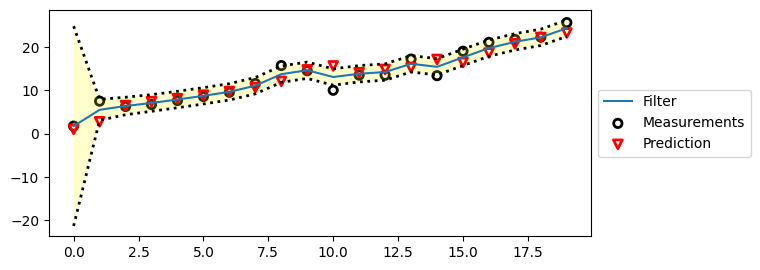

In [65]:
plt.figure(figsize=(7,3), dpi=100)
self_plots.plot_measurements(data[:,1])
self_plots.plot_filter(x_data[:, 0], var=priors[:, 1])
self_plots.plot_predictions(priors[:, 0])
self_plots.show_legend()

## Using filterpy

We have gone over the underlying reasoning behind Kalman filters. Now we will learn simply call it from filterpy library.

https://filterpy.readthedocs.io/en/latest/#filterpy-kalman

The classes in this submodule implement the various Kalman filters. There is also support for smoother functions.

In order to use these variants properly we need to visit the nomenclature of filtering community. Unfortunately, the symbols show variety from book to book, paper to paper but filterpy uses mainstream symbols, which may help you to use other sources as well. 

+ P := variance of the state

+ Q := process noise 

+ R := measurement noise

+ z:= measurement

+ K:= Kalman gain

K is a concept we are already familiar with from our previous discussions on DMD. If we revisit the Bayesian learning formulation for the posterior, the mean is given by:

$\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}$

which can be rewritten as:

$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$

note that $\bar i$ indicates the prior. 

Therefore, we can consider, the variance terms like weighing factors:

$\mu = W_1 \mu_z + W_2 \bar\mu$

If we substitute one of the weights with K;

$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$

the equation becomes:

$\mu = K \mu_z + (1-K) \bar\mu$

$\mu = \bar\mu + K(\mu_z - \bar\mu)$

We can also express the variance as a function of the Kalman gain:

$\sigma^2 = \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2}$

$\sigma^2 = K\sigma_z^2$

$\sigma^2 = (1-K)\bar\sigma^2$

If we rewrite our filter code with these variables, we need the following substitutions:

```
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)
```

This was the way we worked with the g-h filter. It emphasizes taking the residual $y = \mu_z - \bar\mu$, finding the Kalman gain as a ratio of our uncertainty in the prior and measurement $K=P/(P+R)$, and computing the posterior by adding $K_y$ to the prior.

Note that The Bayesian aspect is not visible in this form, as is the fact that we are multiplying the likelihood by the prior. 

This is also the case in `filterpy`:

https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html



### Using filterpy in our example

In [66]:
# Random seeding:
np.random.seed(11)

#Input data:
#-------------------------
#Setting the variances:
Q = 1.618 # variance for the movement of the robot
R = 1.618**3  # variance in the sensory measurements

# Initial position: imagine that we are not confident in this information.
x = 0.
P = 23.**2

u = 1
dt = 1. # time step in seconds

In [67]:
# We have an initial position and a model telling us how the robot moves.
# Lets use the simulator to generate data:
robo_x = RobotSimulator(
    x0=x, 
    velocity=u, 
    measurement_var=R, 
    process_var=Q)

In [68]:
# creating the data...
data = robo_x.run_simulation(dt=1, count=20)
print(data)

[[ 3.23  2.64]
 [ 3.61 -1.85]
 [ 4.6   3.94]
 [ 4.92  5.56]
 [ 6.45  4.26]
 [ 6.32  5.34]
 [ 8.2   9.36]
 [ 7.54  5.24]
 [ 9.48 12.72]
 [10.44  9.03]
 [12.83 12.19]
 [14.76 17.94]
 [16.56 16.71]
 [18.49 17.17]
 [19.26 18.08]
 [20.   19.  ]
 [20.77 19.98]
 [21.88 22.01]
 [23.26 26.14]
 [22.29 24.95]]


In [69]:
#Arrays for plotting:
x_data, priors = np.zeros((N, 2)), np.zeros((N, 2))

for i, z in enumerate(data):
  x,P = kf.predict(x=x, P=P, u=u, Q=Q)
  priors[i] = x,P
  x, P = kf.update(x=x, P=P, z=z[1], R=R)
  x_data[i] = x, P

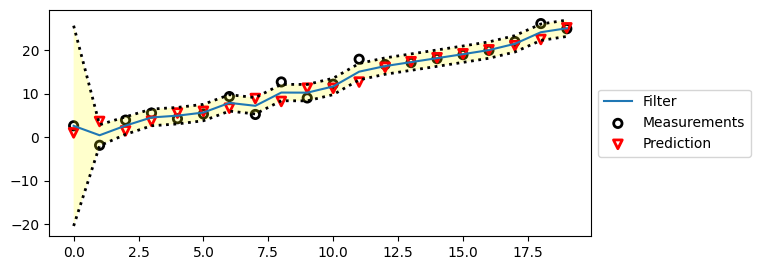

In [70]:
plt.figure(figsize=(7,3), dpi=100)
self_plots.plot_measurements(data[:,1])
self_plots.plot_filter(x_data[:, 0], var=priors[:, 1])
self_plots.plot_predictions(priors[:, 0])
self_plots.show_legend()

# Multivariate Kalman filter

The filterpy implementation of the Kalman filter was already in multidimensional form. We will use it for a multi-dimensional particle tracking problem.

This increase in the number of dimensions necessitaetes the use of a multivariate Gaussian represented with the state vector x and its corresponding covariance matrix P, rather than single values:

$\mathbf x =\begin{bmatrix}x \\ y \\ \dot x \\ \dot y\end{bmatrix}$

This will be now our initial state.

In [71]:
x = np.array([10.0, 10.0, 3., 4.])

In the univariate Kalman filter we specified an initial value for $σ^2$, and then the filter took care of updating its value as measurements were added to the filter. The same thing happens in the multidimensional Kalman filter. We specify an initial value for **P** and the filter updates it during each epoch.

Note that this time P is matrix of uncertainty for all states; a covariance matrix. Since it will be updated at each step in the filtering, we can enter zero for the covariances, unless there is a reason to enter a certain value (an additionall information).


In [72]:
P = np.diag([100., 100., 30., 40.])
print(P)

[[100.   0.   0.   0.]
 [  0. 100.   0.   0.]
 [  0.   0.  30.   0.]
 [  0.   0.   0.  40.]]


The next step is designing the process model. In the 1D case, we used a simple relationship for that purpose:

$x = v \Delta t + x_i$

In multidimensional case, we will use matrix notations to define the governing equations:

$
\begin{bmatrix}x \\ y \\ \dot x \\ \dot y\end{bmatrix}_{t+1}=
\begin{bmatrix}1&0&dt&0 \\ 0&1&0&dt\\ 0&0&1&0\\ 0&0&0&1\end{bmatrix}
\begin{bmatrix}x \\ y \\ \dot x \\ \dot y\end{bmatrix}_{t}
$ 

This matrix is called the state transition function or the state transition matrix,denoted with **F**. It is called function as the matrix is typically replaced by function representations.

The next step is the process noise co-variance matrix **Q** (the noise is assumed to be white). It  gives information about the errors caused during the process. Instead of a single value, here we have a matrix:



$
\begin{bmatrix}σ_{x}^2&σ_{xy}&σ_{x\dot x} &σ_{x\dot y} \\ σ_{yx}&σ_{y}^2&σ_{\dot y x}&σ_{y\dot y}\\ σ_{\dot x x}&σ_{\dot x y}&σ_{\dot x}^2&σ_{\dot x \dot y}\\ σ_{\dot y x}&σ_{\dot y y}&σ_{\dot y \dot x}&σ_{\dot y}^2\end{bmatrix}
$

It is needed to derived from the expected value of the white noise w. For kinematic problems, `filterpy` includes helpe functions for that purpose:

In [73]:
#dim: specifies the dimension of the matrix
# dt: time step in seconds
#var: the variance in the noise 
Q = Q_discrete_white_noise(dim=4, dt=1., var=1.618)
print(Q)

[[0.04 0.13 0.27 0.27]
 [0.13 0.4  0.81 0.81]
 [0.27 0.81 1.62 1.62]
 [0.27 0.81 1.62 1.62]]


Impact of external control variables (like steering, braking, acceleration, etc.) is possible via integrating the control matrix into Kalman filter.

In other words, Kalman filter equations incorporate that knowledge into the filter equations, creating a predicted position based both on current velocity and control inputs to the drive motors. 

In the case of controlled system, prior is determined via:

$\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu}$

where u is the control input and B is the control function (analogous to F). 

When creating a filter, we need to set:

+ x, P: the state and covariance,
+ F, Q: the process model and  process noise co-variance matrix
+ B,u: Optional; the control input and function.


The next step is the information coming from the sensors. Both the measurement **z** and state **x** are vectors so we need to use a matrices to perform the conversion while calculating the posterior. 

The Kalman filter equation that performs this step is:

$
\mathbf y = \mathbf z - \mathbf{H \bar x}
$

where **H** is the measuring matrix or the measurement function. Similarly, noise is represented in an array, that is the measurement noise covariance matrix **R**. The matrix will have dimension m×m, where m is the number of sensors.


## Example: particle tracking in 2D

In [74]:
#creating an object with default values for all the Kalman filter matrices:
#we will see that it initializes F, P, R and Q to the identity matrix. Unknowns are
#taken as zero:
particle_filter = KalmanFilter(dim_x=4, dim_z=2)
particle_filter

KalmanFilter object
dim_x = 4
dim_z = 2
dim_u = 0
x = [[0. 0. 0. 0.]].T
P = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]
x_prior = [[0. 0. 0. 0.]].T
P_prior = [[1. 0. 0. 0.]
           [0. 1. 0. 0.]
           [0. 0. 1. 0.]
           [0. 0. 0. 1.]]
x_post = [[0. 0. 0. 0.]].T
P_post = [[1. 0. 0. 0.]
          [0. 1. 0. 0.]
          [0. 0. 1. 0.]
          [0. 0. 0. 1.]]
F = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]
Q = [[1. 0. 0. 0.]
     [0. 1. 0. 0.]
     [0. 0. 1. 0.]
     [0. 0. 0. 1.]]
R = [[1. 0.]
     [0. 1.]]
H = [[0. 0. 0. 0.]
     [0. 0. 0. 0.]]
K = [[0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]]
y = [[0. 0.]].T
S = [[0. 0.]
     [0. 0.]]
SI = [[0. 0.]
      [0. 0.]]
M = [[0. 0.]
     [0. 0.]]
B = None
z = [[None None]].T
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7f4fe2b5d4d0>

In [75]:
# Aux. function to create case-specific filter object:
# no control over the system here...
def pos_vel_filter(x, P, R, Q=0., dim_x = 4, dim_z = 2, dt=1.0):
    """ Returns a KalmanFilter which implements a
    constant velocity model for a state [x dx].T
    """
    kf = KalmanFilter(dim_x=dim_x, dim_z=dim_z)
    kf.x = np.array([x[0],x[1],x[2],x[3]]) # locations and velocities
    #kinematic equations:
    kf.F = np.array([[1., 0., dt, 0.],
                     [0., 1., 0., dt],
                     [0., 0., 1., 0.],
                     [0., 0., 0., 1.]])  # state transition matrix
    kf.H = np.array([[0., 0., 1., 0.],
                     [0., 0., 0., 1.]])    # Measurement function
    kf.R *= R                     # measurement uncertainty
    if np.isscalar(P):
        kf.P *= P                 # covariance matrix 
    else:
        kf.P[:] = P               # [:] makes deep copy
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=dim_x, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

In [76]:
# We need to pass x,P,Q,R
dt = .1
x = np.array([0., 0., 30., 10.]) 
# calling filter function:
kf = pos_vel_filter(x, P=12, R=6, Q=1, dt=dt)

In [77]:
#Lets see...
kf

KalmanFilter object
dim_x = 4
dim_z = 2
dim_u = 0
x = [ 0.  0. 30. 10.]
P = [[12.  0.  0.  0.]
     [ 0. 12.  0.  0.]
     [ 0.  0. 12.  0.]
     [ 0.  0.  0. 12.]]
x_prior = [[0. 0. 0. 0.]].T
P_prior = [[1. 0. 0. 0.]
           [0. 1. 0. 0.]
           [0. 0. 1. 0.]
           [0. 0. 0. 1.]]
x_post = [[0. 0. 0. 0.]].T
P_post = [[1. 0. 0. 0.]
          [0. 1. 0. 0.]
          [0. 0. 1. 0.]
          [0. 0. 0. 1.]]
F = [[1.  0.  0.1 0. ]
     [0.  1.  0.  0.1]
     [0.  0.  1.  0. ]
     [0.  0.  0.  1. ]]
Q = [[0.   0.   0.   0.  ]
     [0.   0.   0.   0.01]
     [0.   0.   0.01 0.1 ]
     [0.   0.01 0.1  1.  ]]
R = [[6. 0.]
     [0. 6.]]
H = [[0. 0. 1. 0.]
     [0. 0. 0. 1.]]
K = [[0. 0.]
     [0. 0.]
     [0. 0.]
     [0. 0.]]
y = [[0. 0.]].T
S = [[0. 0.]
     [0. 0.]]
SI = [[0. 0.]
      [0. 0.]]
M = [[0. 0.]
     [0. 0.]]
B = None
z = [[None None]].T
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7f4fe

In [128]:
# Data generation:
def compute_data(x, z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x,y, vel_x, vel_y = x[0],x[1],x[2],x[3]
    
    if np.isscalar(z_var):
      z_std_u = math.sqrt(z_var) 
      z_std_v = math.sqrt(z_var)     
    else:
      z_std_u = math.sqrt(z_var[0][0])
      z_std_v = math.sqrt(z_var[1][1])               

    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        u = vel_x + (randn() * p_std)
        v = vel_y + (randn() * p_std)
        x += u*dt
        y += v*dt         
        xs.append([x,y])
        zs.append([u + randn() * z_std_u, y + randn() * z_std_v ])        
    return np.array(xs), np.array(zs)

In [129]:
def run(x0=(0.,0.,0.,0.), P=12, R=6, Q=1, dt=1.0, 
        track=None, zs=None, do_plot=True,
        count=0, **kwargs):
    """
    track is the actual position, 
    zs are the corresponding measurements. 
    """

    # Simulate process if no data provided:
    if zs is None:
        track, zs = compute_data(x0, R, Q, count)

    # create the Kalman filter:
    kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)  

    # run the kalman filter and store the results:
    xs, cov = [], []
    for z in zs:
        kf.predict()
        kf.update(z)
        xs.append(kf.x)
        cov.append(kf.P)

    xs, cov = np.array(xs), np.array(cov)
    if do_plot:
      #x_position:
      self_plots.plot_tracks_2(xs[:, 0], track[:, 0],count=count)

    return xs, cov

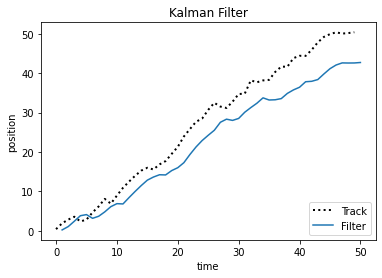

In [132]:
# We need to pass x,P,Q,R
dt = 1
x = np.array([0., 0., 1, 1]) 
R = np.array([[0.1, 0.],
              [0.,1.]]) 
Ms, Ps = run(x0=x, count=50, P=2, R=R, Q=1, dt=dt)

In [133]:
Ms[-1]

array([  42.74, 1212.66,    1.73,   25.08])

In [134]:
Ps[-1]

array([[ 7.37,  0.04,  0.03, -0.07],
       [ 0.04, 51.53, -0.04,  0.95],
       [ 0.03, -0.04,  0.08,  0.08],
       [-0.07,  0.95,  0.08,  0.1 ]])

In [135]:
x0=x
count=50
R=2
Q=1
track, zs = compute_data(x0, R, Q, count)


In [136]:
zs[:3]

array([[ 1.2 ,  0.87],
       [-0.24,  0.52],
       [-0.07,  0.41]])

(<matplotlib.collections.PathCollection at 0x7f4fb23069d0>,)

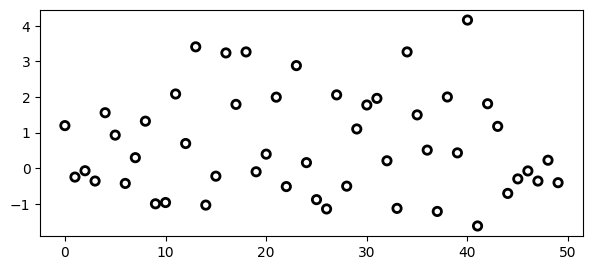

In [137]:
# velocity measurements: u
plt.figure(figsize=(7,3), dpi=100)
self_plots.plot_measurements(zs[:,0])

(<matplotlib.collections.PathCollection at 0x7f4fb2421910>,)

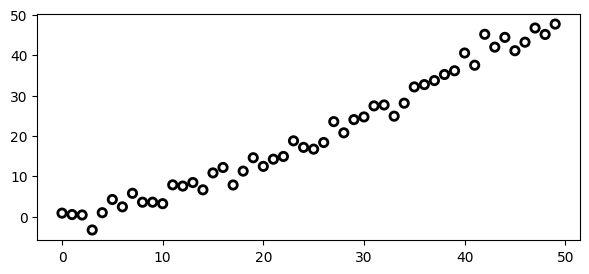

In [138]:
# velocity measurements: v
plt.figure(figsize=(7,3), dpi=100)
self_plots.plot_measurements(zs[:,1])

# References to explore

https://www.youtube.com/watch?v=s_9InuQAx-g

https://www.youtube.com/watch?v=Lgq4R-F8SX8

https://www.youtube.com/watch?v=GmSXhmbv5Zg

https://arxiv.org/ftp/arxiv/papers/1204/1204.0375.pdf

http://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/

https://towardsdatascience.com/kalman-filter-intuition-and-discrete-case-derivation-2188f789ec3a

https://medium.com/self-driving-cars/all-about-kalman-filters-8924abe3aa88

https://github.com/oseiskar/simdkalman

https://en.wikipedia.org/wiki/Probability_density_function

https://en.wikipedia.org/wiki/Central_limit_theorem

https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule

https://en.wikipedia.org/wiki/Cumulative_distribution_function

http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html
